In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Lees de datasets in
data = pd.read_csv("day.csv")
hour = pd.read_csv("hour.csv")


c:\Users\storm\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\storm\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\storm\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\storm\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

Run 1: R² = 0.844, RMSE = 782.96, MAE = 561.30
Run 2: R² = 0.850, RMSE = 766.12, MAE = 576.44
Run 3: R² = 0.800, RMSE = 849.36, MAE = 617.49
Run 4: R² = 0.806, RMSE = 863.02, MAE = 631.25
Run 5: R² = 0.820, RMSE = 826.27, MAE = 588.75

Average over 5 runs:
Mean R²: 0.824
Mean RMSE: 817.55
Mean MAE: 595.05


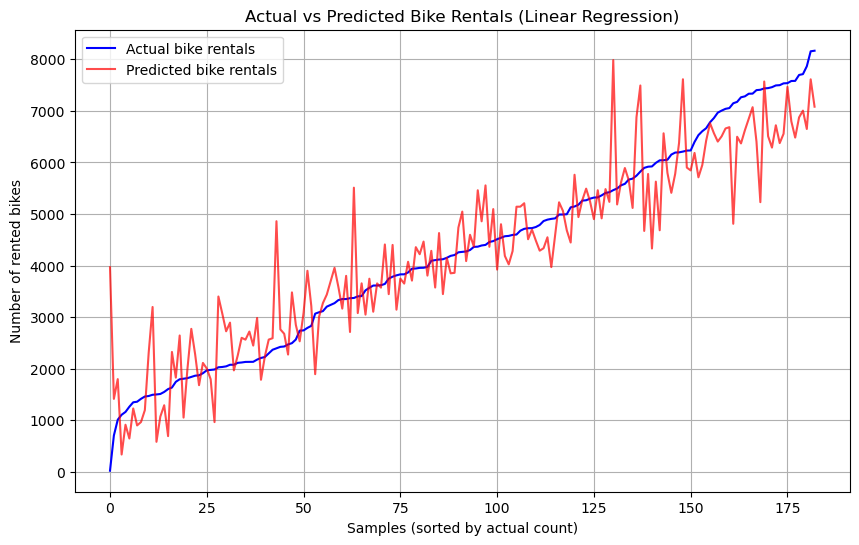

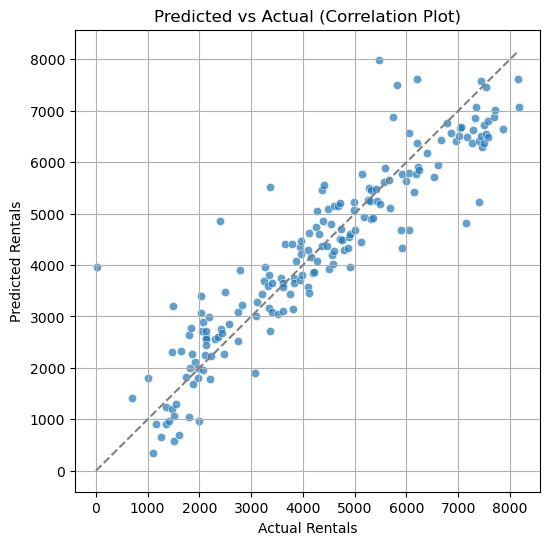

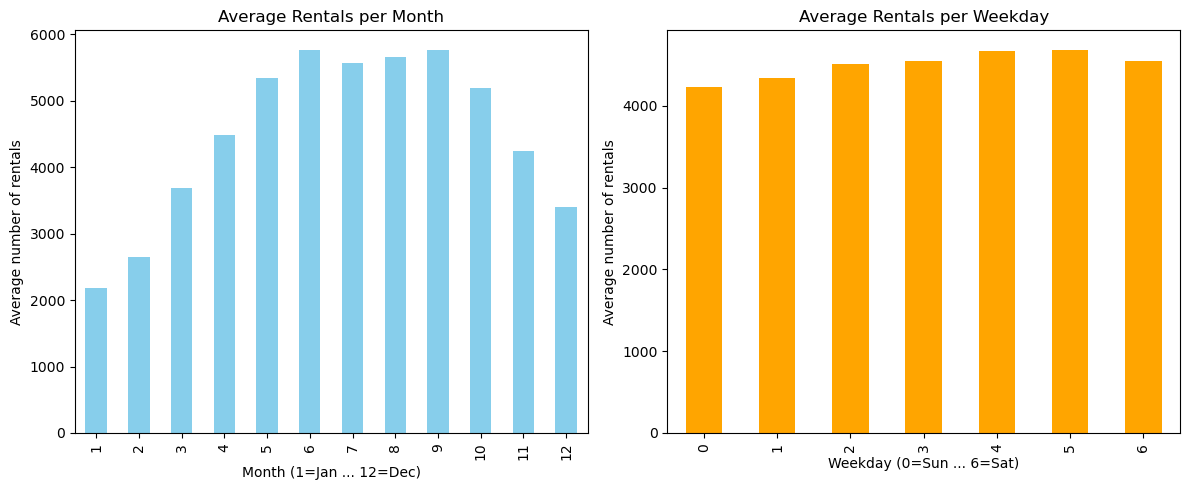


🟢 Most bikes are rented in month 6 and on weekday 5.
That corresponds roughly to the summer season and mid-week days.
Higher temperatures and working days have a strong positive effect on the number of rentals.


In [1]:
# --- Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# --- Load dataset ---
data = pd.read_csv("day.csv")  # of 'hour.csv' als je uurlijkse data wil gebruiken

# --- Select input and output variables ---
X = data[['season','yr','mnth','holiday','weekday','workingday',
          'weathersit','temp','atemp','hum','windspeed']]
y = data['cnt']

# --- One-hot encoding for categorical columns ---
categorical_cols = ['season','mnth','weekday','weathersit']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- Create lists to store results ---
r2_list, rmse_list, mae_list = [], [], []

# --- Repeat the process 5 times with different random splits ---
for i in range(1, 6):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=i)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)

    print(f"Run {i}: R² = {r2:.3f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")

# --- Average metrics over 5 runs ---
print("\nAverage over 5 runs:")
print(f"Mean R²: {np.mean(r2_list):.3f}")
print(f"Mean RMSE: {np.mean(rmse_list):.2f}")
print(f"Mean MAE: {np.mean(mae_list):.2f}")

# --- Train final model on full training set for plotting ---
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- Create a comparison DataFrame for plotting ---
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results = results.sort_values(by='Actual').reset_index(drop=True)

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(10,6))
plt.plot(results['Actual'].values, label='Actual bike rentals', color='blue')
plt.plot(results['Predicted'].values, label='Predicted bike rentals', color='red', alpha=0.7)
plt.title('Actual vs Predicted Bike Rentals (Linear Regression)')
plt.xlabel('Samples (sorted by actual count)')
plt.ylabel('Number of rented bikes')
plt.legend()
plt.grid(True)
plt.show()

# --- Scatter plot for correlation visualization ---
plt.figure(figsize=(6,6))
sns.scatterplot(x='Actual', y='Predicted', data=results, alpha=0.7)
plt.plot([0, max(y_test)], [0, max(y_test)], '--', color='gray')
plt.title('Predicted vs Actual (Correlation Plot)')
plt.xlabel('Actual Rentals')
plt.ylabel('Predicted Rentals')
plt.grid(True)
plt.show()

# --- Analyze when bike rentals are highest ---
avg_by_month = data.groupby('mnth')['cnt'].mean()
avg_by_weekday = data.groupby('weekday')['cnt'].mean()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
avg_by_month.plot(kind='bar', color='skyblue')
plt.title('Average Rentals per Month')
plt.xlabel('Month (1=Jan ... 12=Dec)')
plt.ylabel('Average number of rentals')

plt.subplot(1,2,2)
avg_by_weekday.plot(kind='bar', color='orange')
plt.title('Average Rentals per Weekday')
plt.xlabel('Weekday (0=Sun ... 6=Sat)')
plt.ylabel('Average number of rentals')

plt.tight_layout()
plt.show()

# --- Simple text summary ---
best_month = avg_by_month.idxmax()
best_day = avg_by_weekday.idxmax()

print(f"\n🟢 Most bikes are rented in month {best_month} and on weekday {best_day}.")
print(f"That corresponds roughly to the summer season and mid-week days.")
print("Higher temperatures and working days have a strong positive effect on the number of rentals.")
